# Can you spot the difference between the following images of butterflies?

# Will a CNN spot the differences? Let's discover it!



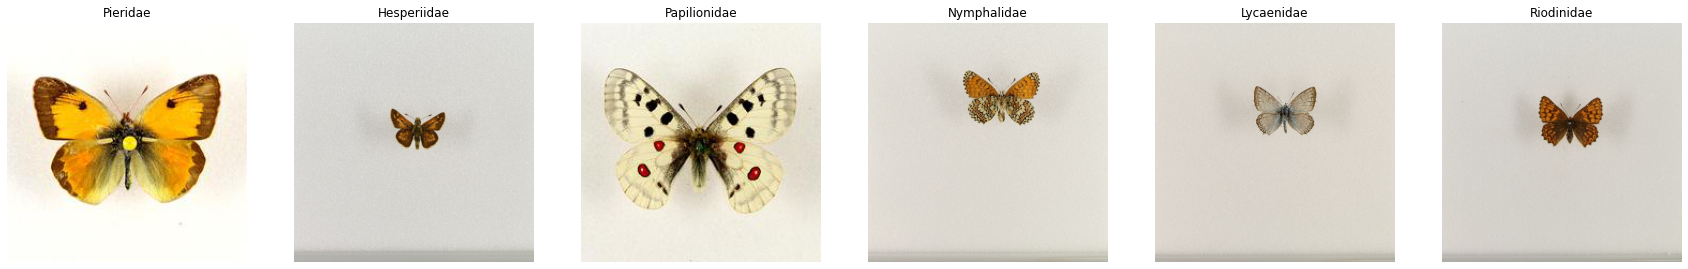

### Classifying butterflies

In this notebook we will experiment with the Convolutional Neural Networks, creating a simple structure that combines some convolutional layers and tradional neural network layers to classify images of butterflies.

How good will it be predicting the family of the butterfly?

### Import libraries

In [1]:
import glob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import classification_report

import tensorflow as tf

from tensorflow.keras import layers, models

### Import data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def df_from_json(json_path, image_path):
  tdf = pd.read_json(json_path, orient='index')
  tdf['image_name'] = tdf['image_path'] + '/' + tdf['image_name']
  tdf['species'] = tdf['genus'] + '_' + tdf['specific_epithet']

  image_path = os.path.join(image_path, '')
  list_image_paths = glob.glob(image_path+'*/*.JPG')
  list_image_paths = [x.replace(image_path,'') for x in list_image_paths]
  check_image_bool = tdf['image_name'].apply(lambda x: x in list_image_paths)
  tdf = tdf[check_image_bool]

  print('loaded {}.jsoyn with shape {}'.format(json_path, tdf.shape))
  return tdf

In [4]:
butterflies_path = "/content/drive/MyDrive/Colab Notebooks/Deep_Learning/day3-4/data/butterflies/"
images_dir = "/content/drive/MyDrive/Colab Notebooks/Deep_Learning/day3-4/data/butterflies/images"

df_train = df_from_json(butterflies_path + "splits/train.json", images_dir)
df_val = df_from_json(butterflies_path + "splits/val.json", images_dir)
df_test = df_from_json(butterflies_path + "splits/test.json", images_dir)

loaded /content/drive/MyDrive/Colab Notebooks/Deep_Learning/day3-4/data/butterflies/splits/train.json.jsoyn with shape (21928, 16)
loaded /content/drive/MyDrive/Colab Notebooks/Deep_Learning/day3-4/data/butterflies/splits/val.json.jsoyn with shape (2979, 16)
loaded /content/drive/MyDrive/Colab Notebooks/Deep_Learning/day3-4/data/butterflies/splits/test.json.jsoyn with shape (3165, 16)


In [5]:
# Check first rows of the training df
df_train.head(2)

,author,barcode,country,dec_lat,dec_long,family,genus,image_name,image_path,infraspecific_epithet,primary_division,specific_epithet,subfamily,subspecific_epithet,token,species
0000e73d-4d1e-4241-a577-88103fc0961c,"(Mayer, 1851)",ETHZ-ENT0012714,Switzerland,46.31000,7.80000,Pieridae,Pieris,2017_04_03R/ETHZ_ENT01_2017_04_03_010614.JPG,2017_04_03R,None,Valais,mannii,Pierinae,None,0000e73d-4d1e-4241-a577-88103fc0961c,Pieris_mannii
000156fb-6f29-4057-b26f-eca7ce9e9460,"(Hübner, 1806)",ETHZ-ENT0015323,Switzerland,46.76594,9.89316,Pieridae,Pieris,2017_04_07R/ETHZ_ENT01_2017_04_07_013503.JPG,2017_04_07R,None,Grisons,bryoniae,Pierinae,None,000156fb-6f29-4057-b26f-eca7ce9e9460,Pieris_bryoniae


In [6]:
# Check number of families (level 1 of the hierarchy)
df_train["family"].unique()

array(['Pieridae', 'Hesperiidae', 'Papilionidae', 'Nymphalidae',
       'Lycaenidae', 'Riodinidae'], dtype=object)

PIERIDAE


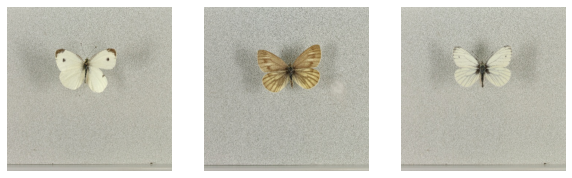

HESPERIIDAE


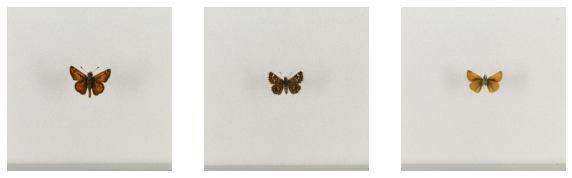

PAPILIONIDAE


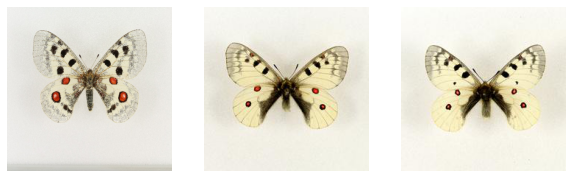

NYMPHALIDAE


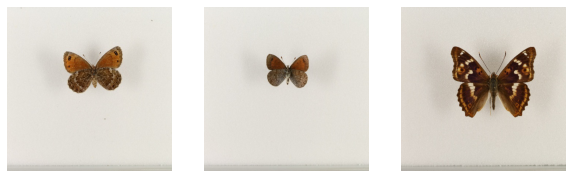

LYCAENIDAE


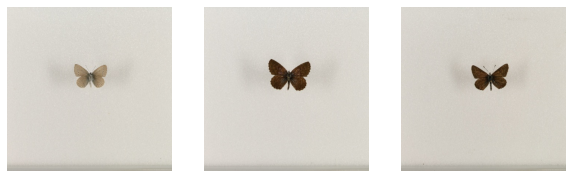

RIODINIDAE


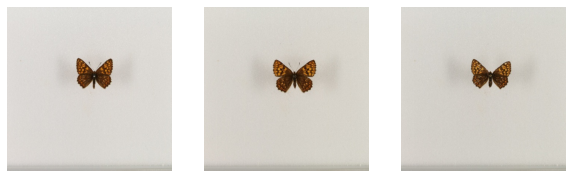

In [27]:
# Plot some images for each one of the 6 categories
for family in df_train["family"].unique().tolist():
  family_df = df_train[df_train["family"] == family]
  images = family_df["image_name"][0:5].values

  paths = []

  for image in images:
    paths.append(os.path.join("/content/drive/MyDrive/Colab Notebooks/Deep_Learning/day3-4/data/butterflies/images/", image))

  print(family.upper())

  fig, ax = plt.subplots(1, 3, figsize=(10,10))

  img = mpimg.imread(paths[0])
  ax[0].imshow(img)
  ax[0].axis('off')

  img = mpimg.imread(paths[1])
  ax[1].imshow(img)
  ax[1].axis('off')

  img = mpimg.imread(paths[2])
  ax[2].imshow(img)
  ax[2].axis('off')

  plt.show();

### Check for class imbalance in each dataframe

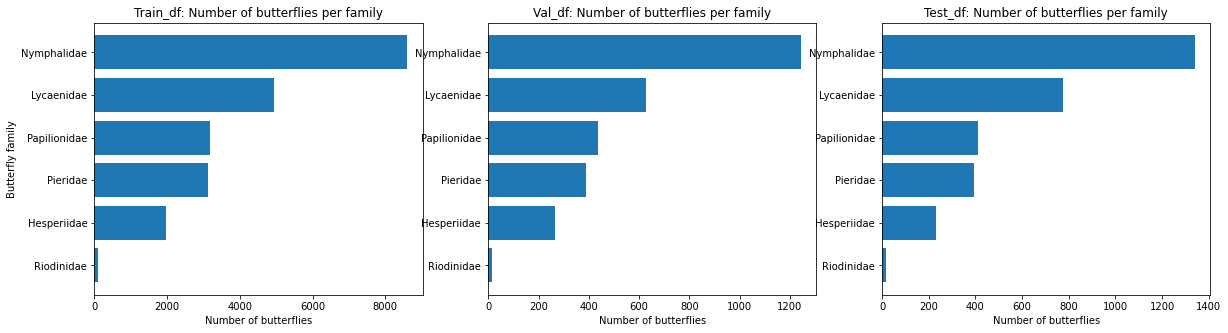

In [69]:
train_classes = df_train["family"].value_counts().sort_values()
val_classes = df_val["family"].value_counts().sort_values()
test_classes = df_test["family"].value_counts().sort_values()

fig, ax = plt.subplots(1,3, figsize=(20,5))

ax[0].barh(train_classes.index, train_classes.values, )
ax[0].set_title("Train_df: Number of butterflies per family")
ax[0].set_xlabel("Number of butterflies")
ax[0].set_ylabel("Butterfly family")

ax[1].barh(val_classes.index, val_classes.values, )
ax[1].set_title("Val_df: Number of butterflies per family")
ax[1].set_xlabel("Number of butterflies")

ax[2].barh(test_classes.index, test_classes.values, )
ax[2].set_title("Test_df: Number of butterflies per family")
ax[2].set_xlabel("Number of butterflies");

In the bar charts above we can see that the distribution of the different families across the different dataframes (training, validation and test) is more or less the same.

The other thing that is important to highlight is that the class "Riodinidae" has way less observations than the rest which can have a negative effect in the final accuracy.

### Images preparation

In [ ]:
# Training data preparation
IMG_SIZE = 224
batch_size = 32

x_col = "image_name"
y_col = "family"

train_classes = df_train[y_col].unique()
train_classes = np.sort(train_classes).tolist()

# We need to rescale the images
datagen_train=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,)

train_generator=datagen_train.flow_from_dataframe(
    dataframe=df_train,
    directory=images_dir,
    shuffle=True,
    x_col=x_col,
    y_col=y_col,
    classes=train_classes,
    class_mode='sparse',
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=batch_size)

Found 21928 validated image filenames belonging to 6 classes.


In [ ]:
# Validation and test data preparation
datagen_val=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

val_generator=datagen_val.flow_from_dataframe(
    dataframe=df_val,
    directory=images_dir, 
    x_col=x_col,
    y_col=y_col,
    class_mode='sparse',
    classes=train_classes,
    shuffle=False,
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=batch_size)

test_generator = datagen_val.flow_from_dataframe(
    dataframe=df_test,
    directory=images_dir, 
    x_col=x_col,
    y_col=y_col,
    class_mode='sparse',
    classes=train_classes,
    shuffle=False,
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=batch_size)

Found 2979 validated image filenames belonging to 6 classes.
Found 3165 validated image filenames belonging to 6 classes.


### Convolutional base

In this section we will create the "feature learning" part of the CNN.

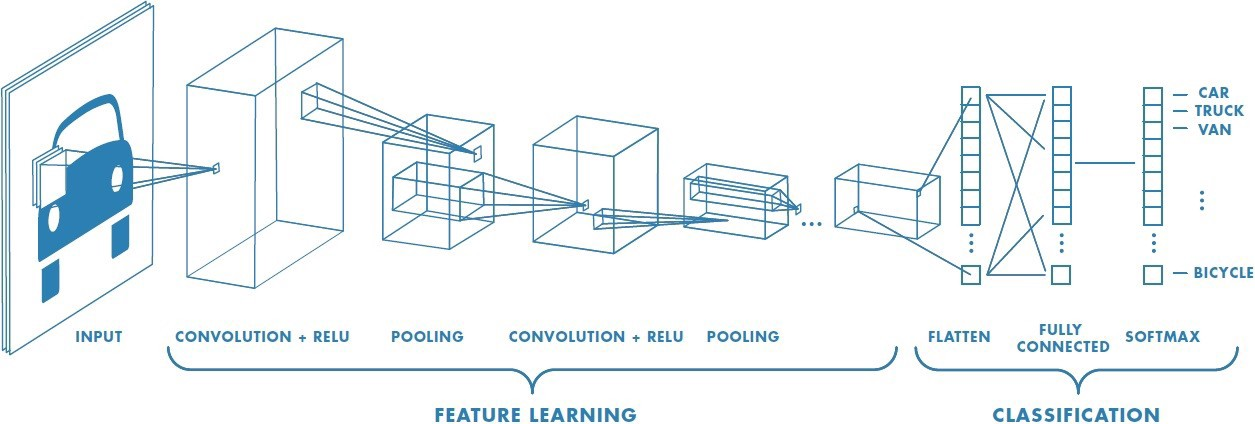

In [ ]:
# Create the convolutional layers of the CNN
model = models.Sequential()

# Convolution_1
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution_2
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution_3
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 64)        18496     
Total params: 23,584
Trainable params: 23,584
Non-trainable params: 0
_________________________________________________________________


### Adding the classification part to the CNN

In [ ]:
# Add the dense layers

# Flatten the matrix of the images
model.add(layers.Flatten())

# Add layer with 256 neurons
model.add(layers.Dense(256, activation='relu'))

# Add layer for the classification of the 6 categories
model.add(layers.Dense(6, activation='softmax'))

In [ ]:
# This is how the final model looks like with all the layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 173056)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)              

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=7)

Epoch 1/7
686/686 [==============================] - 97s 142ms/step - loss: 0.3616 - accuracy: 0.9247 - val_loss: 0.1064 - val_accuracy: 0.9681
Epoch 2/7
686/686 [==============================] - 96s 140ms/step - loss: 0.1143 - accuracy: 0.9675 - val_loss: 0.0640 - val_accuracy: 0.9799
Epoch 3/7
686/686 [==============================] - 97s 141ms/step - loss: 0.0479 - accuracy: 0.9848 - val_loss: 0.0964 - val_accuracy: 0.9742
Epoch 4/7
686/686 [==============================] - 96s 140ms/step - loss: 0.0368 - accuracy: 0.9885 - val_loss: 0.0867 - val_accuracy: 0.9832
Epoch 5/7
686/686 [==============================] - 96s 140ms/step - loss: 0.0151 - accuracy: 0.9954 - val_loss: 0.0473 - val_accuracy: 0.9859
Epoch 6/7
686/686 [==============================] - 97s 141ms/step - loss: 0.0100 - accuracy: 0.9966 - val_loss: 0.0416 - val_accuracy: 0.9896
Epoch 7/7
686/686 [==============================] - 96s 140ms/step - loss: 0.0108 - accuracy: 0.9967 - val_loss: 0.0676 - val_accuracy:

### Evaluate the model

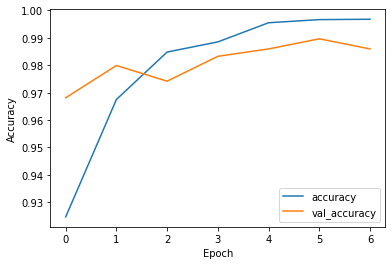

In [ ]:
# Plot accuracy of the training data and the validation data
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right');

In [ ]:
val_loss, val_acc = model.evaluate(val_generator, verbose=2)
print(val_acc)

94/94 - 11s - loss: 0.0676 - accuracy: 0.9859
0.9859012961387634


### Evaluate model performance on test data

In [ ]:
# Predict test labels
predictions = model.predict(test_generator)
predictions.shape

(3165, 6)

In [ ]:
# Get the most probable category
prediction_labels = np.argmax(predictions, axis=1)
prediction_labels.shape

(3165,)

In [ ]:
# Add the labels to the predictions
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in prediction_labels]

In [ ]:
# Add the labels to the real categories of the test dataset
test_labels = [labels[k] for k in test_generator.classes]

In [ ]:
# Create the classification report
print(classification_report(y_true=test_labels, y_pred=predictions))

              precision    recall  f1-score   support

 Hesperiidae       0.97      0.94      0.96       229
  Lycaenidae       0.95      0.93      0.94       777
 Nymphalidae       0.95      0.96      0.96      1340
Papilionidae       0.95      0.99      0.97       409
    Pieridae       0.99      0.93      0.96       394
  Riodinidae       0.38      0.69      0.49        16

    accuracy                           0.95      3165
   macro avg       0.87      0.91      0.88      3165
weighted avg       0.95      0.95      0.95      3165



The f1-score for the Riodinidae family is relativily low. Probably it is caused by the fact that is the category with the least number of pictures.

One option to try to improve the performance for that category would be to apply some kind of imbalance class technique. Maybe oversampling that category and/or undersampling the others.

On the other hand, even though the overall performance is very good (95% accuracy) it is probably caused by the fact that all the pictures have been taken in the same way. The fact that all of them do not have (or have the same) background and at the same position and height allow the CNN not only to learn the shapes and textures but the sizes too, which can be a key factor in the predictions made afterwards.

# Will the CNN be able to classify the second level of the hierarchy with the same precision?

In [ ]:
df_train["subfamily"].unique()

array(['Pierinae', 'Hesperiinae', 'Parnassiinae', 'Satyrinae',
       'Apaturinae', 'Polyommatinae', 'Heliconiinae', 'Coliadinae',
       'Nymphalinae', 'Papilioninae', 'Pyrginae', 'Dismorphiinae',
       'Limenitidinae', 'Nemeobiinae', 'Lycaeninae', 'Theclinae',
       'Heteropterinae', 'Libytheinae', 'Charaxinae', 'Danainae'],
      dtype=object)